# Preprocessing CGE data

In [1]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import boto3
import io
import json
import pandas as pd
import numpy as np
from src.preprocessing.data_preparation_and_cleaning import change_features_names, get_station_name
from src.preprocessing.feature_engineer import get_wind_components, resample_data
from statsmodels.tsa.seasonal import STL

In [2]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    's3',
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    's3',
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [3]:
df_full = []
for year in list(range(2009, 2019+1)):  
    prefix=f"raw/{year}/"
    prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=prefix)
    keys = [obj.key for obj in prefix_objs]
    for key in keys:
        obj = s3_client.get_object(Bucket="cge", Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        df_full.append(df)

In [4]:
cge = pd.concat(df_full, ignore_index=True)
cge = cge.drop_duplicates(ignore_index=True)
cge = get_station_name(cge)
cge[['Posto Nome']] = cge[['Posto Nome']].replace('NaN', '1000300')

cge = cge[[
    'Posto',
    'Posto Nome',
    'DATA',
    'PLU(mm)',
    'Vel.VT(m/s)',
    'Dir.VT(o)',
    'Temp(oC)',
    'Umid.Rel.(%)',
    'Pressão(mb)',
    'Rajada.VT(m/s)',
    'Sens. Térmica(°C)'
    ]]

cge = cge[cge['Posto Nome'].isin(['Sé', 'Lapa', 'Pirituba', 'Penha', 'Jabaquara', 'Parelheiros'])]
cge = change_features_names(cge)

In [17]:
lapa = cge[cge.station_name == "Lapa"] \
    .dropna(subset=["precipitation", "wind_velocity", "wind_direction", "temperature", "relative_humidity", "pressure", "wind_blow"]) \
    .reset_index(drop=True) \
    .drop(["thermal_sensation"], axis=1)

lapa

,station,station_name,timestamp,precipitation,wind_velocity,wind_direction,temperature,relative_humidity,pressure,wind_blow
0,1000848,Lapa,2016-01-21 14:10:00,0.0,5.640,166.041,24.054,62.180,934.53,6.580
1,1000848,Lapa,2016-01-21 14:20:00,0.6,2.068,129.338,24.034,62.821,934.42,6.580
2,1000848,Lapa,2016-01-21 14:30:00,0.6,1.880,100.178,23.983,59.360,934.36,5.264
3,1000848,Lapa,2016-01-21 14:40:00,0.6,2.444,168.234,23.822,60.172,934.72,7.332
4,1000848,Lapa,2016-01-21 14:50:00,0.6,2.256,161.165,23.903,59.659,935.08,7.520
...,...,...,...,...,...,...,...,...,...,...
157738,1000848,Lapa,2019-02-18 22:10:00,0.0,0.000,159.136,24.527,82.646,931.63,2.068
157739,1000848,Lapa,2019-02-18 22:20:00,0.0,0.000,157.964,24.376,83.934,931.18,0.000
157740,1000848,Lapa,2019-02-18 22:30:00,0.0,0.000,135.862,24.225,84.697,931.76,2.820
157741,1000848,Lapa,2019-02-18 22:40:00,0.0,0.000,134.891,23.943,85.295,931.78,0.000


In [15]:
rural = cge[cge.station_name == "Parelheiros"][["timestamp", "temperature"]]
rural

,timestamp,temperature
2372749,2012-08-13 18:10:00,NaN
2372750,2012-08-14 15:30:00,18.383
2372751,2012-08-14 15:40:00,18.625
2372752,2012-08-14 15:50:00,18.726
2372753,2012-08-14 16:00:00,19.099
...,...,...
11735844,2019-02-18 22:00:00,20.942
11735845,2019-02-18 22:10:00,20.871
11735846,2019-02-18 22:20:00,20.660
11735847,2019-02-18 22:30:00,20.609


In [18]:
lapa = lapa.merge(rural.rename(columns={"temperature": "rural_temperature"}), on="timestamp")
lapa["uhi"] = lapa.temperature - lapa.rural_temperature 
lapa = lapa.drop("rural_temperature", axis=1)
lapa

,station,station_name,timestamp,precipitation,wind_velocity,wind_direction,temperature,relative_humidity,pressure,wind_blow,uhi
0,1000848,Lapa,2016-01-21 14:10:00,0.0,5.640,166.041,24.054,62.180,934.53,6.580,0.705
1,1000848,Lapa,2016-01-21 14:20:00,0.6,2.068,129.338,24.034,62.821,934.42,6.580,0.967
2,1000848,Lapa,2016-01-21 14:30:00,0.6,1.880,100.178,23.983,59.360,934.36,5.264,1.259
3,1000848,Lapa,2016-01-21 14:40:00,0.6,2.444,168.234,23.822,60.172,934.72,7.332,1.339
4,1000848,Lapa,2016-01-21 14:50:00,0.6,2.256,161.165,23.903,59.659,935.08,7.520,1.098
...,...,...,...,...,...,...,...,...,...,...,...
157736,1000848,Lapa,2019-02-18 22:00:00,0.0,0.000,182.327,24.890,80.888,931.12,3.384,3.948
157737,1000848,Lapa,2019-02-18 22:10:00,0.0,0.000,159.136,24.527,82.646,931.63,2.068,3.656
157738,1000848,Lapa,2019-02-18 22:20:00,0.0,0.000,157.964,24.376,83.934,931.18,0.000,3.716
157739,1000848,Lapa,2019-02-18 22:30:00,0.0,0.000,135.862,24.225,84.697,931.76,2.820,3.616


In [19]:
lapa = get_wind_components(
    lapa, 
    wind_velocity='wind_velocity', 
    wind_direction='wind_direction', 
    x_name='wind_velocity_x', 
    y_name='wind_velocity_y'
    )

lapa = lapa.drop(['wind_velocity'], axis=1)

lapa = get_wind_components(
    lapa, 
    wind_velocity='wind_blow', 
    wind_direction='wind_direction', 
    x_name='wind_blow_x', 
    y_name='wind_blow_y'
    )

lapa = lapa.drop(['wind_blow'], axis=1)
lapa = lapa.drop(['wind_direction'], axis=1)
lapa = resample_data(lapa)
lapa = lapa.reset_index()
lapa = lapa.set_index("timestamp")

lapa

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule='60min').mean()


,precipitation,temperature,relative_humidity,pressure,uhi,wind_velocity_x,wind_velocity_y,wind_blow_x,wind_blow_y,station,station_name
timestamp,,,,,,,,,,,
2016-01-21 14:00:00,0.48,23.959200,60.838400,934.622000,1.073600,-2.328878,1.207415,-5.156431,3.156087,1000848,Lapa
2016-01-21 15:00:00,0.60,24.260500,59.027167,934.495000,0.900167,-2.345159,1.383109,-3.926744,3.178061,1000848,Lapa
2016-01-21 16:00:00,0.60,24.631000,56.776833,934.336667,1.757333,-3.118908,1.691404,-5.939076,3.450454,1000848,Lapa
2016-01-21 17:00:00,0.60,24.642833,55.731833,934.245000,1.762333,-1.820458,1.629404,-3.763557,4.095237,1000848,Lapa
2016-01-21 18:00:00,0.60,24.625833,55.659833,933.590000,2.415333,-3.149486,1.046056,-5.778626,1.970324,1000848,Lapa
...,...,...,...,...,...,...,...,...,...,...,...
2019-02-18 18:00:00,0.00,27.068333,67.378167,930.448333,2.385333,0.987694,-1.814244,3.193784,-4.762114,1000848,Lapa
2019-02-18 19:00:00,0.00,26.657000,69.979500,930.051667,2.933833,0.917986,-0.961140,2.594402,-4.523592,1000848,Lapa
2019-02-18 20:00:00,0.00,26.392000,71.525833,930.355000,3.944667,0.097844,-0.196218,1.376222,-3.055869,1000848,Lapa


In [20]:
cols = [
    'uhi',
    'precipitation',
    'temperature',
    'relative_humidity',
    'pressure',
    'wind_velocity_x',
    'wind_velocity_y',
    'wind_blow_x',
    'wind_blow_y'
    ]

In [21]:
def get_outliers(df, features, factor):
    for feature in features:
        df_ = df.copy()
        df_rolling_stats = df_[feature].rolling(window=24, center=True, min_periods=1).agg({"rolling_mean": "mean", "rolling_std": "std"})
        df_[["rolling_mean", "rolling_std"]] = df_rolling_stats
        df[f"{feature}_outlier"] = np.abs(df_[feature] - df_["rolling_mean"]) > factor * df_["rolling_std"]
        df[f"{feature}_outlier"] = df[f"{feature}_outlier"].astype(int)
    return df

In [22]:
lapa = get_outliers(df=lapa, features=cols, factor=2)

In [24]:
outliers = lapa[["temperature", "temperature_outlier"]][lapa.temperature_outlier == 1].drop("temperature_outlier", axis=1)
outliers

,temperature
timestamp,
2016-01-24 16:00:00,28.136000
2016-01-27 15:00:00,29.457000
2016-02-02 17:00:00,31.499833
2016-02-05 17:00:00,32.172833
2016-02-11 15:00:00,27.983167
...,...
2019-02-06 21:00:00,18.685667
2019-02-06 22:00:00,18.700667
2019-02-15 19:00:00,23.412667


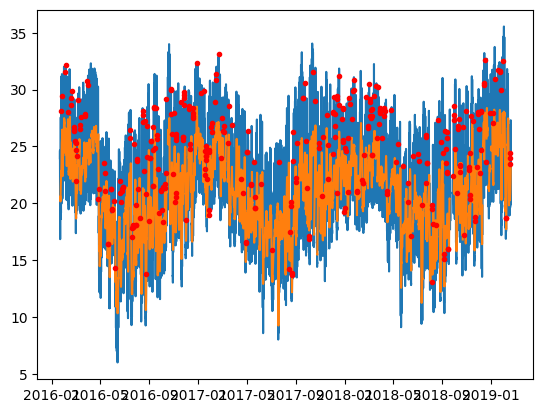

In [25]:
import matplotlib.pyplot as plt
plt.plot(lapa.temperature)
plt.plot(lapa.temperature.rolling(24).mean())
plt.plot(outliers.temperature, ls="", marker=".", color="red")
plt.show()

In [26]:
cols = list(lapa.drop(["station", "station_name"], axis=1).columns)
cols

['precipitation',
 'temperature',
 'relative_humidity',
 'pressure',
 'uhi',
 'wind_velocity_x',
 'wind_velocity_y',
 'wind_blow_x',
 'wind_blow_y',
 'uhi_outlier',
 'precipitation_outlier',
 'temperature_outlier',
 'relative_humidity_outlier',
 'pressure_outlier',
 'wind_velocity_x_outlier',
 'wind_velocity_y_outlier',
 'wind_blow_x_outlier',
 'wind_blow_y_outlier']

In [27]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from sklearn.pipeline import Pipeline

In [28]:
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_month",
        "hour",
    ],
)

lagf = LagFeatures(
    variables=cols, # the input variables
    freq=[f"{i}H" for i in range(1,37)], # move 1 hr to 36 hrs forward
    missing_values="ignore"
)

winf = WindowFeatures(
    variables=cols, # the input variables
    window=["3H", "6H", "12H", "24H"], # average of 3, 6, 12 and 24 previous hours
    freq="1H", # move 1 hr forward
    functions=["mean", "std", "min", "max"],
    missing_values="ignore"
)

cyclicf = CyclicalFeatures(
    variables=["month", "hour"], # The features we want to transform.
    drop_original=False, # Whether to drop the original features.
)

pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
    ]
)

lapa = pipe.fit_transform(lapa)
lapa = lapa.drop(["station", "station_name"], axis=1)

In [29]:
# lapa.to_csv("../data/processed/lapa.csv", index=True)
lapa.to_csv("../data/processed/lapa2.csv", index=True)

: 